# Imports:

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [28]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import random
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
# Parameter tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from scikeras.wrappers import KerasClassifier



import json

# ATCNet Model imports
import models

In [4]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [5]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [6]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [7]:
def epoch_label_extractor(Data, epoch_length=1123, num_channels=64):
    df = Data.to_data_frame()
    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    number_of_epochs = int(len(df)/epoch_length)
    
    randomlist = random.sample(range(number_of_epochs), number_of_epochs)

    data = np.zeros((number_of_epochs,num_channels, epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    for i in range(number_of_epochs):
        data[i,:,:] = X[:, randomlist[i]*epoch_length:(randomlist[i] + 1)*epoch_length]
        if (df['condition'][randomlist[i]*epoch_length] == 'Left'):
            labels[i,0] = 0
        elif(df['condition'][randomlist[i]*epoch_length] == 'Right'):
            labels[i,0] = 1
        elif(df['condition'][randomlist[i]*epoch_length] == 'Feet'):
            labels[i,0] = 2
        elif(df['condition'][randomlist[i]*epoch_length] == 'Tongue'):
            labels[i,0] = 3
        elif(df['condition'][randomlist[i]*epoch_length] == 'Mis'):
            labels[i,0] = 4
        elif(df['condition'][randomlist[i]*epoch_length] == 'Si'):
            labels[i,0] = 5
        elif(df['condition'][randomlist[i]*epoch_length] == 'Rest'):
            labels[i,0] = 6
        elif(df['condition'][randomlist[i]*epoch_length] == 'Ls'):
            labels[i,0] = 7
        elif(df['condition'][randomlist[i]*epoch_length] == 'Rs'):
            labels[i,0] = 8
        elif(df['condition'][randomlist[i]*epoch_length] == 'Fs'):
            labels[i,0] = 9
        else:
            labels[i,0] = 10
        
    return data, labels

In [8]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [9]:
def class_extraction(classes, data, labels):
    mask = np.isin(labels[:, 0], classes)
    dataset = data[mask, :, :]
    Final_labels = labels[mask, :]
    return dataset, Final_labels

In [10]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [11]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, filter_length=50)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [12]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [13]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [14]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# ATCNet Model:

In [15]:
def getModel(model_name, dataset_conf):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://doi.org/10.1109/TII.2022.3197419
        model = models.ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu'
            )     
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

In [16]:
dataset = 'BCI2a'
in_samples = 1000                   # Changed!!!
n_channels = 22
n_sub = 9
n_classes = 4
classes_labels = ['Left hand', 'Right hand','Foot','Tongue']



# Set dataset paramters as dataset configuration
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'isStandard': True, 'LOSO': True}


# Set training hyperparamters as train configuration
train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
              'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

model = getModel(train_conf.get('model'), dataset_conf)
    

2024-05-05 15:31:09.005533: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 15:31:11.444368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-05 15:31:11.446919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-05-05 15:31:11.449209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1362

In [ ]:
model.summary()

In [18]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
           dropoutRate = 0.5, kernLength = 64, F1 = 8, 
           D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout',
           learning_rate=0.0009):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 8))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 40),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 16))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [19]:
def EEGNet_Modified(nb_classes=4, Chans = 64, Samples = 1123, 
                    dropoutRate = 0.3, kernLength = 64, F1 = 8, 
                    D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout',
                    learning_rate=0.001):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    
    block1       = Conv2D(20, (Chans, kernLength), padding='same', use_bias = False)(input1)
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(block1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 8))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 40),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 16))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


A Multi-branch Multi-scale Convolutional Neural Network for Motor Imagery Classification.
* The Model architecture:

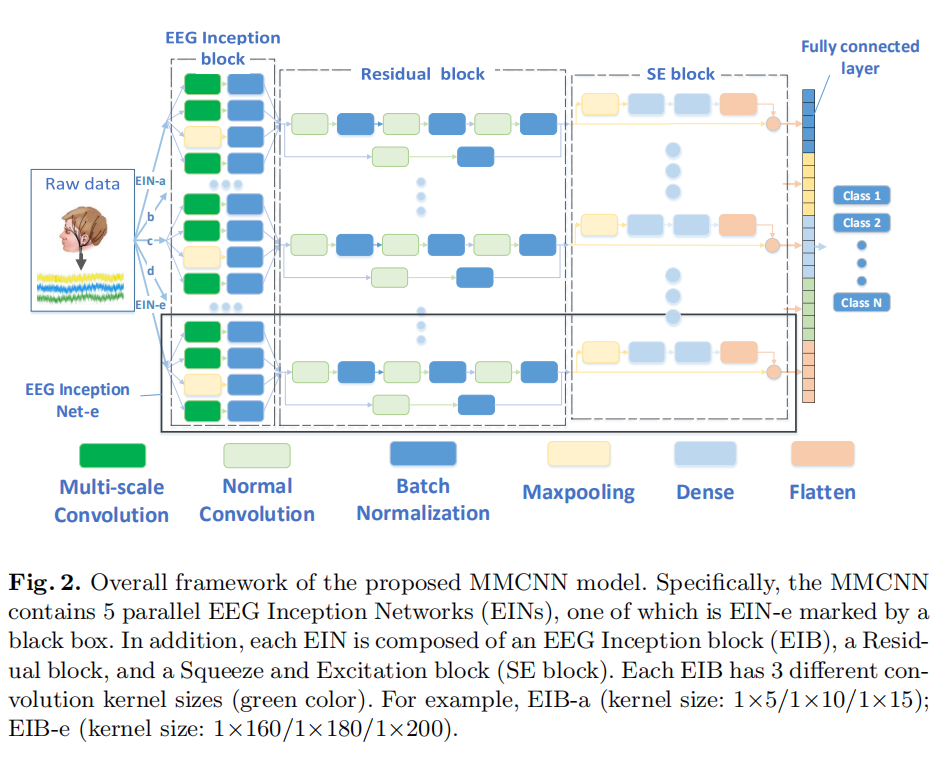

In [20]:
from keras.layers import Add
from keras.layers import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D, Dense, Activation, Flatten, Input, Lambda, Reshape, GlobalAveragePooling1D, Dense, multiply, BatchNormalization
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras import regularizers
from keras import metrics
from keras import losses
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import concatenate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from keras import optimizers

class MMCNN_model():
    
    
    def __init__(self,
                channels = 3,
                samples = 1000,
                dropout = 0.8):
        self.channels = channels
        self.samples = samples
        self.activation = 'elu'
        self.learning_rate = 0.0001
        self.dropout = 0.8
        self.inception_filters = [16,16,16,16]
        # the parameter of the first part :EEG Inception block
        self.inception_kernel_length = [[5,10,15,10],
                                   [40,45,50,100],
                                   [60,65,70,100],
                                   [80,85,90,100],
                                   [160,180,200,180],]
        self.inception_stride = [2,4,4,4,16]
        self.first_maxpooling_size = 4
        self.first_maxpooling_stride = 4
        # the parameter of the second part :Residual block       
        self.res_block_filters = [16,16,16]
        self.res_block_kernel_stride = [8,7,7,7,6]
        # the parameter of the third part :SE block
        self.se_block_kernel_stride = 16
        self.se_ratio = 8
        self.second_maxpooling_size = [4,3,3,3,2]
        self.second_maxpooling_stride = [4,3,3,3,2]
        
        
        self.model = self.build_model(self.channels,self.samples)
        adam = optimizers.Adam(learning_rate = self.learning_rate) 
        self.model.compile(loss=losses.binary_crossentropy,
                           optimizer = adam,
                           metrics=['mae',metrics.binary_accuracy])
            
    def build_model(self,channels,samples):
        output_conns = []
        input_tensor = Input(shape = (samples,channels))  
                
        '''
        EIN-a
        '''
        x = self.inception_block(input_tensor,
                                 self.inception_filters,
                                 self.inception_kernel_length[0],
                                 self.inception_stride[0],
                                 self.activation)

        x = layers.MaxPooling1D(pool_size = self.first_maxpooling_size,
                                strides = self.first_maxpooling_stride,
                                padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Dropout(self.dropout)(x)
        x = self.conv_block(x,
                            self.res_block_filters,
                            self.res_block_kernel_stride[0],
                            activation = self.activation)
        
        x = self.squeeze_excitation_layer(x,
                                          self.se_block_kernel_stride,
                                          self.activation,
                                          ratio = self.se_ratio)
        x = layers.MaxPooling1D(pool_size = self.second_maxpooling_size[0],
                                strides = self.second_maxpooling_stride[0],
                                padding = 'same')(x)
        x = layers.Flatten()(x)
        output_conns.append(x)

        '''
        EIN-b
        '''
        y1 = self.inception_block(input_tensor,
                                  self.inception_filters,
                                  self.inception_kernel_length[1],
                                  self.inception_stride[1],
                                  self.activation)
        y1 = layers.MaxPooling1D(pool_size = self.first_maxpooling_size,
                                 strides = self.first_maxpooling_stride,
                                 padding = 'same')(y1)
        y1 = BatchNormalization()(y1)
        y1 = layers.Dropout(self.dropout)(y1)
        y1 = self.conv_block(y1,
                             self.res_block_filters,
                             self.res_block_kernel_stride[1],
                             self.activation)
        y1 = self.squeeze_excitation_layer(y1,
                                           self.se_block_kernel_stride,
                                           self.activation,
                                           ratio = self.se_ratio)
        y1 = layers.MaxPooling1D(pool_size = self.second_maxpooling_size[1],
                                 strides = self.second_maxpooling_stride[1],
                                 padding = 'same')(y1)
        y1 = layers.Flatten()(y1)
        output_conns.append(y1)

        '''
        EIN-c
        '''
        y2 = self.inception_block(input_tensor,
                                  self.inception_filters,
                                  self.inception_kernel_length[2],
                                  self.inception_stride[2],
                                  self.activation)
        y2 = layers.MaxPooling1D(pool_size = self.first_maxpooling_size,
                                 strides = self.first_maxpooling_stride,
                                 padding = 'same')(y2)
        y2 = BatchNormalization()(y2)
        y2 = layers.Dropout(self.dropout)(y2)
        y2 = self.conv_block(y2,
                             self.res_block_filters,
                             self.res_block_kernel_stride[2],
                             self.activation)
        y2 = self.squeeze_excitation_layer(y2,
                                           self.se_block_kernel_stride,
                                           self.activation,
                                           ratio = self.se_ratio)
        y2 = layers.MaxPooling1D(pool_size = self.second_maxpooling_size[2],
                                 strides = self.second_maxpooling_stride[2],
                                 padding = 'same')(y2)
        y2 = layers.Flatten()(y2)
        output_conns.append(y2)


        '''
        EIN-d
        '''
        y3 = self.inception_block(input_tensor,
                                  self.inception_filters,
                                  self.inception_kernel_length[3],
                                  self.inception_stride[3],
                                  self.activation)
        y3 = layers.MaxPooling1D(pool_size = self.first_maxpooling_size,
                                 strides = self.first_maxpooling_stride,
                                 padding = 'same')(y3)
        y3 = BatchNormalization()(y3)
        y3 = layers.Dropout(self.dropout)(y3) 
        y3 = self.conv_block(y3,
                             self.res_block_filters,
                             self.res_block_kernel_stride[3],
                             self.activation)
        y3 = self.squeeze_excitation_layer(y3,
                                           self.se_block_kernel_stride,
                                           self.activation,
                                           ratio = self.se_ratio)
        y3 = layers.MaxPooling1D(pool_size = self.second_maxpooling_size[3],
                                 strides = self.second_maxpooling_stride[3],
                                 padding = 'same')(y3)
        y3 = layers.Flatten()(y3)
        output_conns.append(y3)

        '''
        EIN-e
        '''
        z = self.inception_block(input_tensor,
                                 self.inception_filters,
                                 self.inception_kernel_length[4],
                                 self.inception_stride[4],
                                 self.activation)
        z = layers.MaxPooling1D(pool_size = self.first_maxpooling_size,
                                strides = self.first_maxpooling_stride,
                                padding = 'same')(z)
        z = BatchNormalization()(z)
        z = layers.Dropout(self.dropout)(z)
        z = self.conv_block(z,
                            self.res_block_filters,
                            self.res_block_kernel_stride[4],
                            self.activation)
        z = self.squeeze_excitation_layer(z,
                                          self.se_block_kernel_stride,
                                          self.activation,
                                          ratio = self.se_ratio)
        z = layers.MaxPooling1D(pool_size = self.second_maxpooling_size[4],
                                strides = self.second_maxpooling_stride[4],
                                padding = 'same')(z)
        z = layers.Flatten()(z)
        output_conns.append(z)

        output_conns = layers.Concatenate(axis = -1)(output_conns)
        output_conns = layers.Dropout(self.dropout)(output_conns)
        output_tensor = layers.Dense(2,activation = 'sigmoid')(output_conns)
    #     output_tensor = layers.Dense(4,activation = 'softmax')(output_conns)
        model = Model(input_tensor,output_tensor)
        return model
        
    '''
    se_block
    '''
    def squeeze_excitation_layer(self,x,out_dim,activation,ratio=8):

        squeeze = GlobalAveragePooling1D()(x)

        excitation = Dense(units = out_dim//ratio)(squeeze)
        excitation = Activation(activation)(excitation)
        excitation = Dense(units = out_dim,activation='sigmoid')(excitation)
        excitation = Reshape((1,out_dim))(excitation)

        scale = multiply([x,excitation])
        return scale
        
    '''
    res_block
    '''
    def conv_block(self,x,nb_filter,length,activation):
        k1,k2,k3 = nb_filter

        out = layers.Conv1D(k1,length,strides=1,padding='same',kernel_regularizer=regularizers.l2(0.002))(x)
        out = BatchNormalization()(out)
        out = Activation(activation)(out)

        out = layers.Conv1D(k2,length,strides=1,padding='same',kernel_regularizer=regularizers.l2(0.002))(out)
        out = BatchNormalization()(out)
        out = Activation(activation)(out)

        out = layers.Conv1D(k3,length,strides=1,padding='same',kernel_regularizer=regularizers.l2(0.002))(out)
        out = BatchNormalization()(out)

        x = layers.Conv1D(k3,1,strides = 1,padding = 'same')(x)
        x = BatchNormalization()(x)

        out = Add()([out,x])
        out = Activation(activation)(out)
        out = layers.Dropout(self.dropout)(out)
        return out
    
    '''
    inception_block 
    '''
    def inception_block(self,x,ince_filter,ince_length,stride,activation):
        k1,k2,k3,k4 = ince_filter
        l1,l2,l3,l4 = ince_length
        inception = []

        x1 = layers.Conv1D(k1,l1,strides = stride,padding = 'same',kernel_regularizer=regularizers.l2(0.01))(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation(activation)(x1)
        inception.append(x1)

        x2 = layers.Conv1D(k2,l2,strides = stride,padding = 'same',kernel_regularizer=regularizers.l2(0.01))(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation(activation)(x2)
        inception.append(x2)

        x3 = layers.Conv1D(k3,l3,strides = stride,padding = 'same',kernel_regularizer=regularizers.l2(0.01))(x)
        x3 = BatchNormalization()(x3)
        x3 = Activation(activation)(x3)
        inception.append(x3)

        x4 = layers.MaxPooling1D(pool_size = l4 ,strides = stride,padding = 'same')(x)
        x4 = layers.Conv1D(k4,1,strides = 1,padding = 'same')(x4)
        x4 = BatchNormalization()(x4)
        x4 = Activation(activation)(x4)
        inception.append(x4)
        v1 = layers.Concatenate(axis = -1)(inception)

        return v1

ImportError: cannot import name 'to_categorical' from 'keras.utils' (/home/bijan/tf1/lib/python3.10/site-packages/keras/utils/__init__.py)

In [ ]:
MMCNN = MMCNN_model(channels = 3,samples = 1000)
model = MMCNN.model

In [ ]:
model.summary()

In [21]:
fake_data = np.random.rand(120, 1000, 3)
fake_label = np.random.randint(4, size=(120, 2))
model.fit(fake_data, fake_label, epochs=10)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Activation, Flatten, Input, Lambda, Reshape, BatchNormalization, Dropout, concatenate, multiply
from tensorflow.keras import Model, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score

class MMCNN_model():
    def __init__(self, channels=3, samples=1000, dropout=0.8):
        self.channels = channels
        self.samples = samples
        self.activation = 'elu'
        self.learning_rate = 0.0001
        self.dropout = dropout
        self.inception_filters = [16, 16, 16, 16]
        self.inception_kernel_length = [[5, 10, 15, 10],
                                       [40, 45, 50, 100],
                                       [60, 65, 70, 100],
                                       [80, 85, 90, 100],
                                       [160, 180, 200, 180]]
        self.inception_stride = [2, 4, 4, 4, 16]
        self.first_maxpooling_size = 4
        self.first_maxpooling_stride = 4
        self.res_block_filters = [16, 16, 16]
        self.res_block_kernel_stride = [8, 7, 7, 7, 6]
        self.se_block_kernel_stride = 16
        self.se_ratio = 8
        self.second_maxpooling_size = [4, 3, 3, 3, 2]
        self.second_maxpooling_stride = [4, 3, 3, 3, 2]

        self.model = self.build_model(self.channels, self.samples)
        adam = optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=adam,
                           metrics=['accuracy'])

    def build_model(self, channels, samples):
        output_conns = []
        input_tensor = Input(shape=(samples, channels))

        x = self.inception_block(input_tensor,
                                 self.inception_filters,
                                 self.inception_kernel_length[0],
                                 self.inception_stride[0],
                                 self.activation)

        x = MaxPooling1D(pool_size=self.first_maxpooling_size,
                         strides=self.first_maxpooling_stride,
                         padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout)(x)
        x = self.conv_block(x,
                            self.res_block_filters,
                            self.res_block_kernel_stride[0],
                            activation=self.activation)

        x = self.squeeze_excitation_layer(x,
                                          self.se_block_kernel_stride,
                                          self.activation,
                                          ratio=self.se_ratio)
        x = MaxPooling1D(pool_size=self.second_maxpooling_size[0],
                         strides=self.second_maxpooling_stride[0],
                         padding='same')(x)
        x = Flatten()(x)
        output_conns.append(x)

        output_conns = concatenate(output_conns, axis=-1)
        output_conns = Dropout(self.dropout)(output_conns)
        output_tensor = Dense(4, activation='sigmoid')(output_conns)

        model = Model(input_tensor, output_tensor)
        return model

    def squeeze_excitation_layer(self, x, out_dim, activation, ratio=8):
        squeeze = GlobalAveragePooling1D()(x)
        excitation = Dense(units=out_dim // ratio)(squeeze)
        excitation = Activation(activation)(excitation)
        excitation = Dense(units=out_dim, activation='sigmoid')(excitation)
        excitation = Reshape((1, out_dim))(excitation)
        scale = multiply([x, excitation])
        return scale

    def conv_block(self, x, nb_filter, length, activation):
        k1, k2, k3 = nb_filter
        out = Conv1D(k1, length, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.002))(x)
        out = BatchNormalization()(out)
        out = Activation(activation)(out)
        out = Conv1D(k2, length, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.002))(out)
        out = BatchNormalization()(out)
        out = Activation(activation)(out)
        out = Conv1D(k3, length, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.002))(out)
        out = BatchNormalization()(out)
        x = Conv1D(k3, 1, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        out = Add()([out, x])
        out = Activation(activation)(out)
        out = Dropout(self.dropout)(out)
        return out

    def inception_block(self, x, ince_filter, ince_length, stride, activation):
        k1, k2, k3, k4 = ince_filter
        l1, l2, l3, l4 = ince_length
        inception = []

        x1 = Conv1D(k1, l1, strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation(activation)(x1)
        inception.append(x1)

        x2 = Conv1D(k2, l2, strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation(activation)(x2)
        inception.append(x2)

        x3 = Conv1D(k3, l3, strides=stride, padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
        x3 = BatchNormalization()(x3)
        x3 = Activation(activation)(x3)
        inception.append(x3)

        x4 = MaxPooling1D(pool_size=l4, strides=stride, padding='same')(x)
        x4 = Conv1D(k4, 1, strides=1, padding='same')(x4)
        x4 = BatchNormalization()(x4)
        x4 = Activation(activation)(x4)
        inception.append(x4)

        v1 = concatenate(inception, axis=-1)
        return v1


In [23]:
MMCNN = MMCNN_model(channels = 64,samples = 1123)
model = MMCNN.model

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1123, 64)]   0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 562, 64)      0           ['input_2[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 562, 16)      5136        ['input_2[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 562, 16)      10256       ['input_2[0][0]']                
                                                                                            

In [ ]:
fake_data = np.random.rand(120, 1123, 64)
fake_label = np.random.randint(4, size=(120, 4))
model.fit(fake_data, fake_label, epochs=10)

Epoch 1/10


2024-05-05 15:30:51.039996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-05 15:30:51.534629: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 15:30:51.540233: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 15:30:51.540415: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-05 15:30:51.544500: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 15:30:51.544726: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the EEGNet model
model = EEGNet(nb_classes=4, Chans=22, Samples=1000, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the EEGNet model
model = EEGNet_Modified(nb_classes=4, Chans=22, Samples=1000, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


In [ ]:
if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
    print("Running on cloud ...")
    print("Please make sure to modify how you read the data according to your need!\n\n")
    raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase1"
           

# Data reading:

In [18]:
path[0]

'/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI'

In [19]:
try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase2"
        
    elif path[0] == "'pwd' is not recognized as an internal or external command,":
        print("Running local ...")
        print("Please make sure to change the data path!\n\n")
        raw_data_path = "D:\Hadi_BCI\Recordings\Phase 2\PreProcessedData\P16toP30"
        
except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:\Hadi_BCI\Recordings\Phase 2\PreProcessedData\P16toP30"
    
    

data_epochs = []
data_labels = []
all_data_epochs = []
all_data_labels = []

for participant_id in range(16, 31):
    
    participant_T = f"P{participant_id}"
    file_path_T = f"{raw_data_path}/{participant_T}.set"

    raw_data = mne.read_epochs_eeglab(file_path_T)


    epochs, labels = epoch_label_extractor(raw_data, epoch_length=1123, num_channels=64)
    
    class_1=0 # Left
    class_2=1 # Right
    class_3=2 # Feet
    class_4=5 # Si
    
    classes = [class_1, class_2, class_3, class_4]
    num_channels = 64
    epoch_length = 1123
    
    data_epochs, data_labels = class_extraction(classes, epochs, labels)
    
    all_data_epochs.append(data_epochs)
    all_data_labels.append(data_labels)


Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P16.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P17.set...
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P18.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P19.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P20.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P21.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P22.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P23.set...
Not setting metadata
479 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P24.set...
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P25.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P26.set...
Not setting metadata
479 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P27.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P28.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P29.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P30.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_237940/3712936874.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.


In [20]:
for i in range(15):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)


Subject 1 train epochs:     (240, 64, 1123)     Subject 1 train labels:     (240, 1)
Subject 2 train epochs:     (80, 64, 1123)     Subject 2 train labels:     (80, 1)
Subject 3 train epochs:     (240, 64, 1123)     Subject 3 train labels:     (240, 1)
Subject 4 train epochs:     (240, 64, 1123)     Subject 4 train labels:     (240, 1)
Subject 5 train epochs:     (240, 64, 1123)     Subject 5 train labels:     (240, 1)
Subject 6 train epochs:     (240, 64, 1123)     Subject 6 train labels:     (240, 1)
Subject 7 train epochs:     (240, 64, 1123)     Subject 7 train labels:     (240, 1)
Subject 8 train epochs:     (240, 64, 1123)     Subject 8 train labels:     (240, 1)
Subject 9 train epochs:     (80, 64, 1123)     Subject 9 train labels:     (80, 1)
Subject 10 train epochs:     (240, 64, 1123)     Subject 10 train labels:     (240, 1)
Subject 11 train epochs:     (240, 64, 1123)     Subject 11 train labels:     (240, 1)
Subject 12 train epochs:     (240, 64, 1123)     Subject 12 train

In [21]:
all_data_labels[1][:, 0]

array([1, 5, 2, 5, 1, 5, 5, 2, 1, 1, 5, 2, 0, 0, 5, 2, 2, 0, 2, 0, 0, 5,
       5, 2, 2, 0, 5, 0, 0, 5, 0, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0,
       5, 5, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 0, 0, 5, 5, 5, 1, 5, 2, 0, 2,
       1, 1, 5, 0, 0, 1, 5, 5, 0, 5, 0, 1, 0, 1])

In [22]:
raw_data

Number of events,480
Events,Feet: 60Fs: 60Left: 60Ls: 60Rest: 60Right: 60Rs: 60Si: 60
Time range,-0.496 – 3.992 s
Baseline,off


In [23]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 1)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (240, 1, 64, 1123)     All label shape (sub 0):      (240, 1)
All data epoch shape (sub 1):     (80, 1, 64, 1123)     All label shape (sub 1):      (80, 1)
All data epoch shape (sub 2):     (240, 1, 64, 1123)     All label shape (sub 2):      (240, 1)
All data epoch shape (sub 3):     (240, 1, 64, 1123)     All label shape (sub 3):      (240, 1)
All data epoch shape (sub 4):     (240, 1, 64, 1123)     All label shape (sub 4):      (240, 1)
All data epoch shape (sub 5):     (240, 1, 64, 1123)     All label shape (sub 5):      (240, 1)
All data epoch shape (sub 6):     (240, 1, 64, 1123)     All label shape (sub 6):      (240, 1)
All data epoch shape (sub 7):     (240, 1, 64, 1123)     All label shape (sub 7):      (240, 1)
All data epoch shape (sub 8):     (80, 1, 64, 1123)     All label shape (sub 8):      (80, 1)
All data epoch shape (sub 9):     (240, 1, 64, 1123)     All label shape (sub 9):      (240, 1)
All data epoch shape (sub 10):     (240, 1, 

In [24]:
all_data_labels[1][:10]

array([[1],
       [5],
       [2],
       [5],
       [1],
       [5],
       [5],
       [2],
       [1],
       [1]])

# Encoding

In [25]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [26]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 15
labels Length: 15



Participant 16 - Epochs[0] shape: (240, 1)
Participant 16 - labels[0] shape: (240, 4)



Participant 16 - labels[0]:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


# Within Subject:

In [ ]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009




for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        dataset = 'BCI2a'
        in_samples = 1123                   # Changed!!!
        n_channels = 64
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']


        # Set dataset paramters as dataset configuration
        dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                        'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                        'isStandard': True, 'LOSO': True}


        # Set training hyperparamters as train configuration
        train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
                      'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

        model = getModel(train_conf.get('model'), dataset_conf)


        model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])


        patience = 30
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        # Normalizing the features
        mean = train_epochs.mean(axis=(0, 2), keepdims=True)
        std = train_epochs.std(axis=(0, 2), keepdims=True)

        print(mean.shape)
        print(std.shape)

        norm_train_epochs = (train_epochs - mean) / std
        norm_test_epochs = (test_epochs - mean) / std
        

        # Train the model
        history = model.fit(
            norm_train_epochs, train_labels,
            validation_data=(norm_test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=32,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(norm_test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [ ]:
participants[0]

In [ ]:
print(len(all_tests_pred))

In [20]:
print(np.concatenate(all_tests_pred[4]).shape)

(288,)


In [46]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 15):
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
    
    y_true = np.array(all_y_true[i-1])
    y_pred = np.array(all_y_pred[i-1])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [44]:
confusion_matrices[3]

array([[40,  8, 11, 10],
       [ 8, 41, 13,  8],
       [ 8, 24, 29,  9],
       [20, 21,  9, 20]])

In [98]:
del confusion_matrices[3]

In [99]:
confusion_matrices[3]

array([[63,  1,  5,  3],
       [ 1, 60,  1, 10],
       [ 5,  4, 56,  7],
       [ 3,  7, 13, 49]])

In [90]:
print(confusion_matrices[1])

[[44 14  9  5]
 [14 36 11 11]
 [ 5  3 60  4]
 [ 7  6  2 57]]


In [47]:
print(len(confusion_matrices))

14


In [48]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [49]:
print("Dataset: Hadi - Phase I")
print("The within-subject scenario:")
print("Algorithm: EEGNet")
print("Accuracy: ", acc)

normalized

Dataset: Hadi - Phase I
The within-subject scenario:
Algorithm: EEGNet
Accuracy:  0.46638557161645283


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.441394,0.229145,0.184794,0.144667
Right (True),0.206316,0.483158,0.158947,0.151579
Feet (True),0.158061,0.180190,0.461538,0.200211
Tongue (True),0.139094,0.161222,0.220232,0.479452


In [26]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      576
Tongue (True)    576
dtype: int64

In [27]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.74609375

# Cross-subjects (With hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
      Test index:                                         [12]



Epoch 1/500
95/95 [==============================] - 14s 77ms/step - loss: 16.7152 - accuracy: 0.2520 - val_loss: 12.0091 - val_accuracy: 0.2708
Epoch 2/500
95/95 [==============================] - 6s 63ms/step - loss: 9.1438 - accuracy: 0.3303 - val_loss: 6.7803 - val_accuracy: 0.2792
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.2469 - accuracy: 0.3842 - val_loss: 3.9103 - val_accuracy: 0.5750
Epoch 4/500
95/95 [========

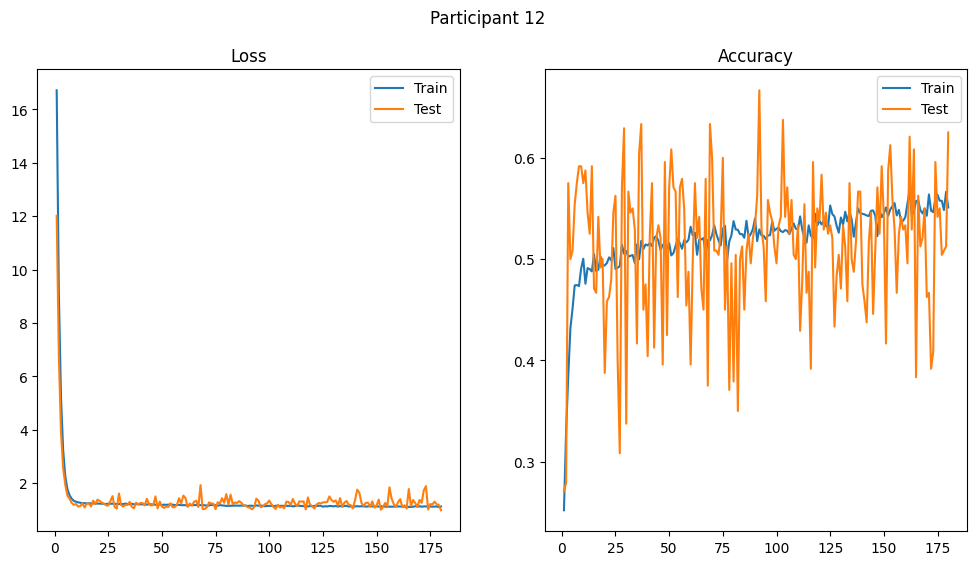

Outer Loop 2 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [5]



Epoch 1/500
95/95 [==============================] - 14s 76ms/step - loss: 16.4796 - accuracy: 0.2566 - val_loss: 11.8002 - val_accuracy: 0.2875
Epoch 2/500
95/95 [==============================] - 6s 64ms/step - loss: 9.0401 - accuracy: 0.2786 - val_loss: 6.6659 - val_accuracy: 0.3500
Epoch 3/500
95/95 [==============================] - 6s 64ms/step - loss: 5.2025 - accuracy: 0.3253 - val_loss: 3.9075 - val_accuracy: 0.4250
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

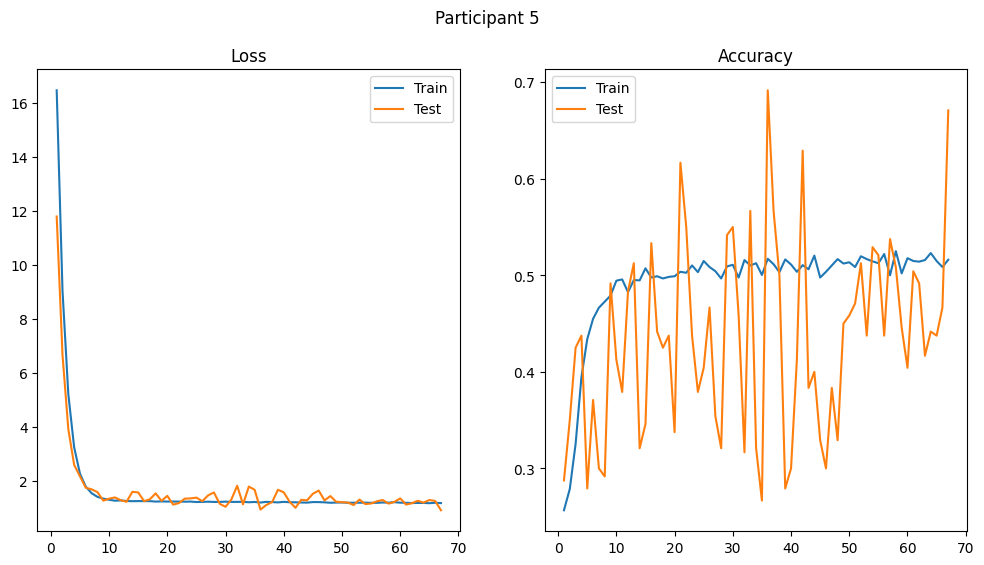

Outer Loop 3 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [6]



Epoch 1/500
95/95 [==============================] - 14s 75ms/step - loss: 16.0110 - accuracy: 0.2635 - val_loss: 11.5195 - val_accuracy: 0.2500
Epoch 2/500
95/95 [==============================] - 6s 62ms/step - loss: 8.8512 - accuracy: 0.2928 - val_loss: 6.5763 - val_accuracy: 0.2500
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.1564 - accuracy: 0.3299 - val_loss: 4.0495 - val_accuracy: 0.2500
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

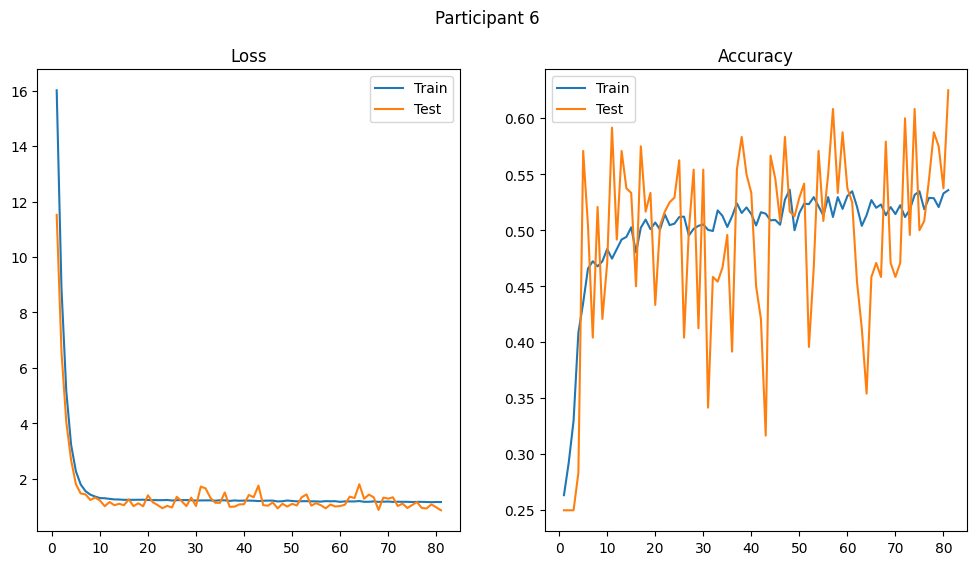

Outer Loop 4 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [1]



Epoch 1/500
95/95 [==============================] - 14s 75ms/step - loss: 15.2021 - accuracy: 0.2592 - val_loss: 10.8322 - val_accuracy: 0.3000
Epoch 2/500
95/95 [==============================] - 6s 62ms/step - loss: 8.2400 - accuracy: 0.3095 - val_loss: 6.1775 - val_accuracy: 0.2708
Epoch 3/500
95/95 [==============================] - 6s 62ms/step - loss: 4.7212 - accuracy: 0.4033 - val_loss: 3.8306 - val_accuracy: 0.2875
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

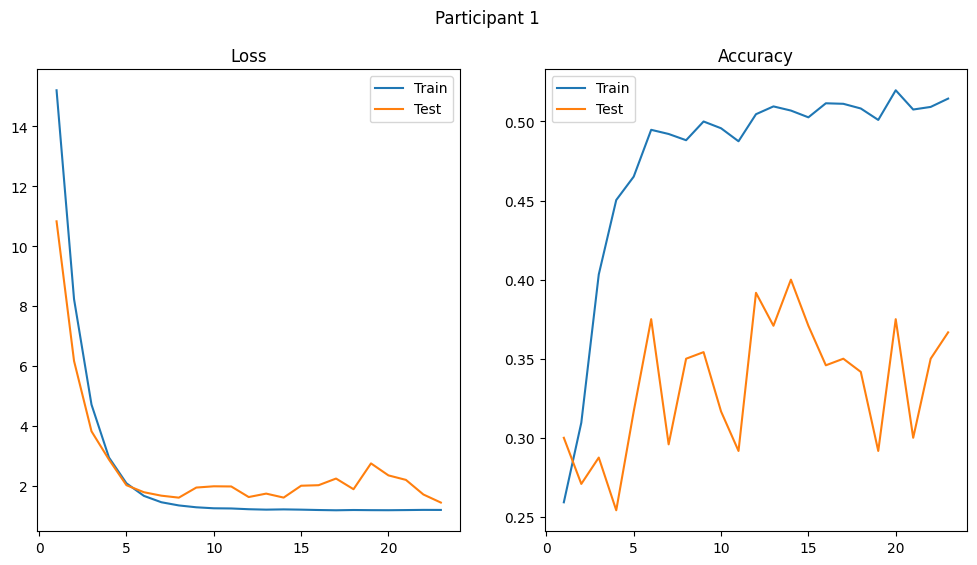

Outer Loop 5 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
      Test index:                                         [10]



Epoch 1/500
95/95 [==============================] - 14s 77ms/step - loss: 16.7300 - accuracy: 0.2569 - val_loss: 11.9675 - val_accuracy: 0.2917
Epoch 2/500
95/95 [==============================] - 6s 64ms/step - loss: 9.1309 - accuracy: 0.2809 - val_loss: 6.7229 - val_accuracy: 0.2750
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.2310 - accuracy: 0.3260 - val_loss: 4.0031 - val_accuracy: 0.3875
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

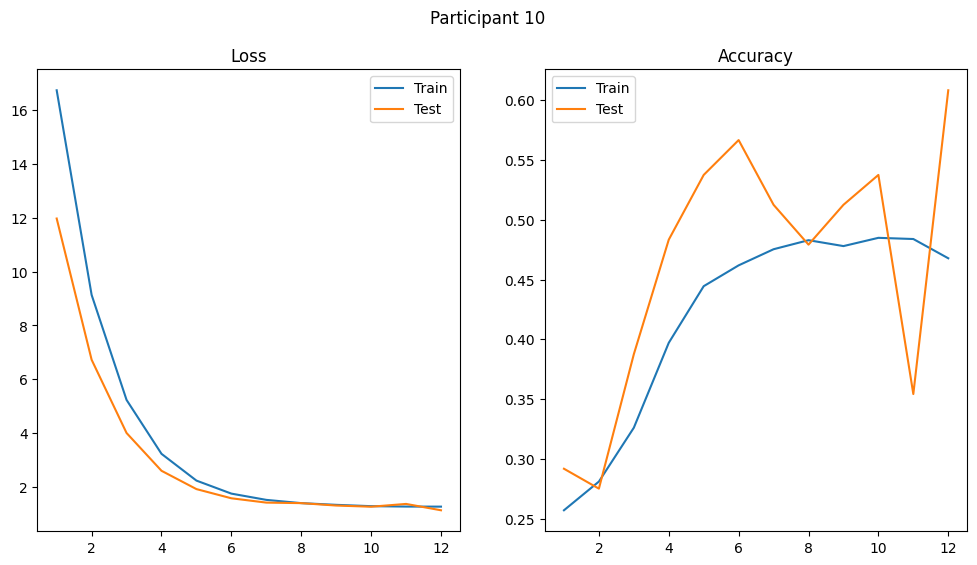

Outer Loop 6 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [4]



Epoch 1/500
95/95 [==============================] - 14s 75ms/step - loss: 16.8470 - accuracy: 0.2803 - val_loss: 12.0893 - val_accuracy: 0.2500
Epoch 2/500
95/95 [==============================] - 6s 61ms/step - loss: 9.2425 - accuracy: 0.3036 - val_loss: 6.8663 - val_accuracy: 0.2458
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.3067 - accuracy: 0.3724 - val_loss: 4.1392 - val_accuracy: 0.3667
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

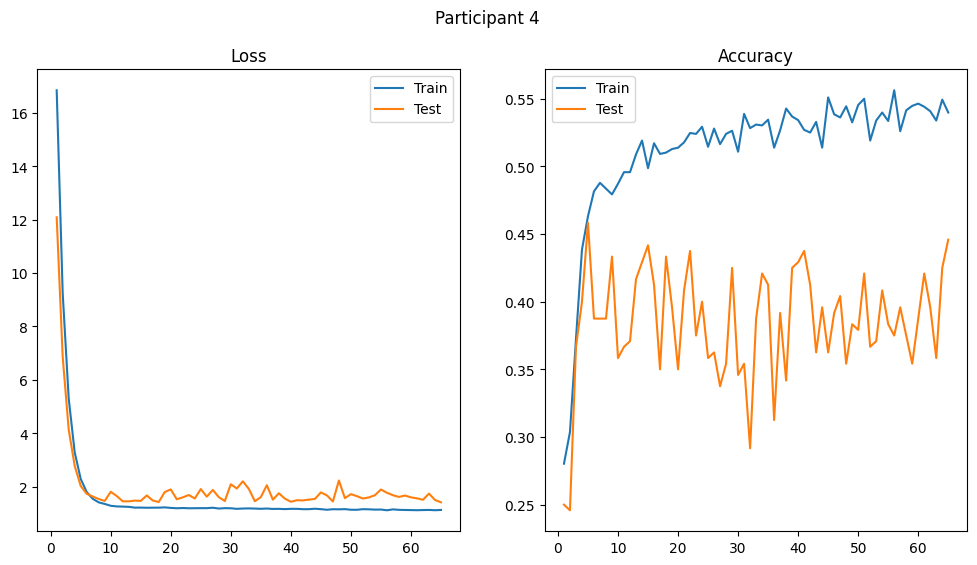

Outer Loop 7 

      Train epochs' shape:                                (3200, 1, 64, 1123)
      Test epochs' shape:                                 (80, 1, 64, 1123)
      Test labels' shape:                                 (80, 4)
      Train labels' shape (without encoding):             (3200, 1)
      Test labels' shape (without encoding):              (80, 1)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [2]



Epoch 1/500
100/100 [==============================] - 14s 73ms/step - loss: 16.0728 - accuracy: 0.2491 - val_loss: 11.3330 - val_accuracy: 0.2500
Epoch 2/500
100/100 [==============================] - 6s 62ms/step - loss: 8.5499 - accuracy: 0.3162 - val_loss: 6.3335 - val_accuracy: 0.2750
Epoch 3/500
100/100 [==============================] - 6s 63ms/step - loss: 4.8141 - accuracy: 0.3931 - val_loss: 4.2479 - val_accuracy: 0.2750
Epoch 4/500
100/100 [===

<Figure size 640x480 with 0 Axes>

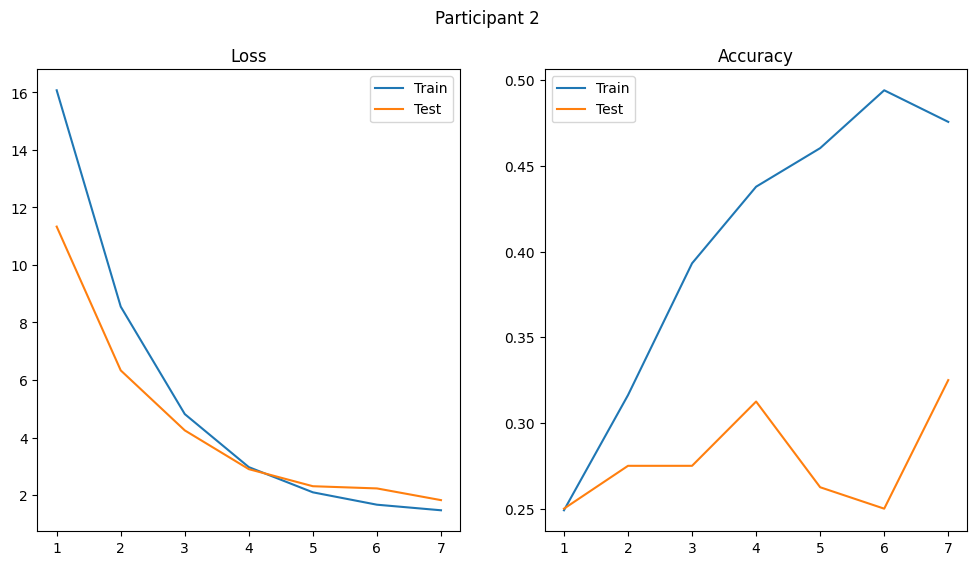

Outer Loop 8 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15]
      Test index:                                         [11]



Epoch 1/500
95/95 [==============================] - 15s 79ms/step - loss: 16.9321 - accuracy: 0.2628 - val_loss: 12.1430 - val_accuracy: 0.2750
Epoch 2/500
95/95 [==============================] - 6s 63ms/step - loss: 9.2722 - accuracy: 0.3112 - val_loss: 6.8576 - val_accuracy: 0.2875
Epoch 3/500
95/95 [==============================] - 6s 61ms/step - loss: 5.3073 - accuracy: 0.3789 - val_loss: 4.0901 - val_accuracy: 0.3083
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

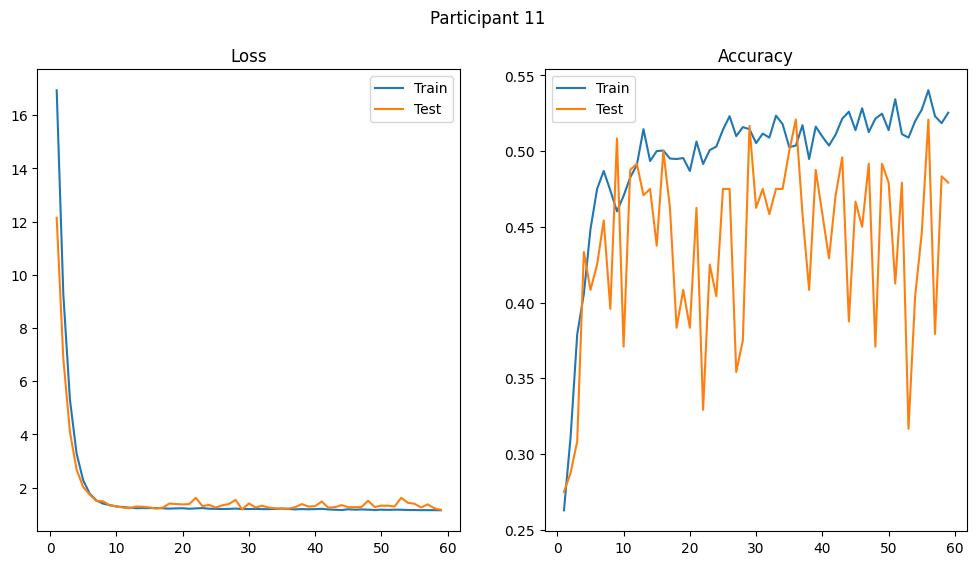

Outer Loop 9 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [8]



Epoch 1/500
95/95 [==============================] - 14s 76ms/step - loss: 15.9153 - accuracy: 0.2678 - val_loss: 11.3847 - val_accuracy: 0.3000
Epoch 2/500
95/95 [==============================] - 6s 61ms/step - loss: 8.6711 - accuracy: 0.3151 - val_loss: 6.4508 - val_accuracy: 0.3417
Epoch 3/500
95/95 [==============================] - 6s 62ms/step - loss: 4.9668 - accuracy: 0.3954 - val_loss: 3.9603 - val_accuracy: 0.3125
Epoch 4/500
95/95 [========

<Figure size 640x480 with 0 Axes>

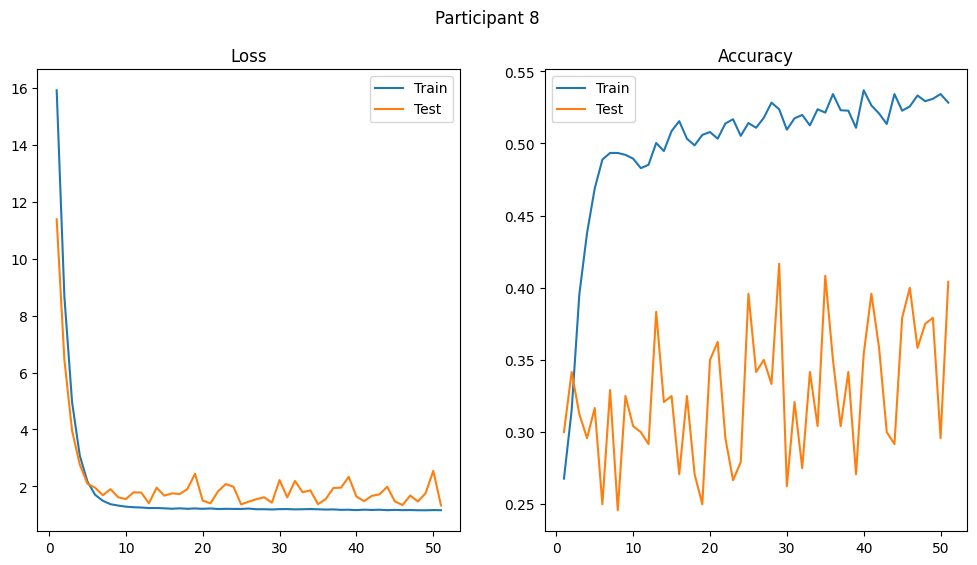

Outer Loop 10 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
      Test index:                                         [13]



Epoch 1/500
95/95 [==============================] - 14s 76ms/step - loss: 16.6626 - accuracy: 0.2638 - val_loss: 12.0272 - val_accuracy: 0.2333
Epoch 2/500
95/95 [==============================] - 6s 63ms/step - loss: 9.1759 - accuracy: 0.3313 - val_loss: 6.8885 - val_accuracy: 0.2375
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.2825 - accuracy: 0.3951 - val_loss: 4.2299 - val_accuracy: 0.2625
Epoch 4/500
95/95 [=======

<Figure size 640x480 with 0 Axes>

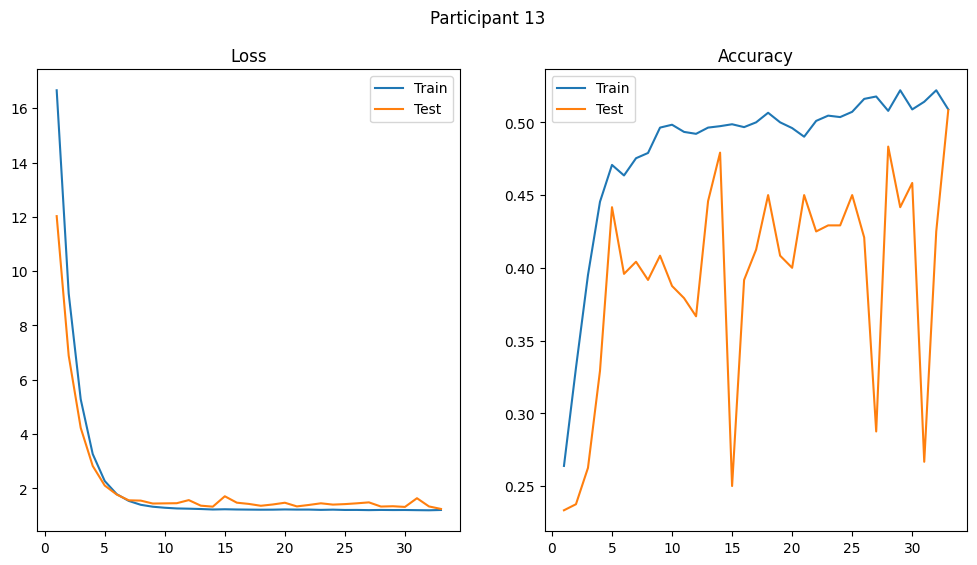

Outer Loop 11 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [3]



Epoch 1/500
95/95 [==============================] - 14s 77ms/step - loss: 16.4640 - accuracy: 0.2724 - val_loss: 11.8274 - val_accuracy: 0.2500
Epoch 2/500
95/95 [==============================] - 6s 64ms/step - loss: 8.9738 - accuracy: 0.3451 - val_loss: 6.7104 - val_accuracy: 0.3417
Epoch 3/500
95/95 [==============================] - 6s 65ms/step - loss: 5.1344 - accuracy: 0.4036 - val_loss: 4.1253 - val_accuracy: 0.3458
Epoch 4/500
95/95 [=======

<Figure size 640x480 with 0 Axes>

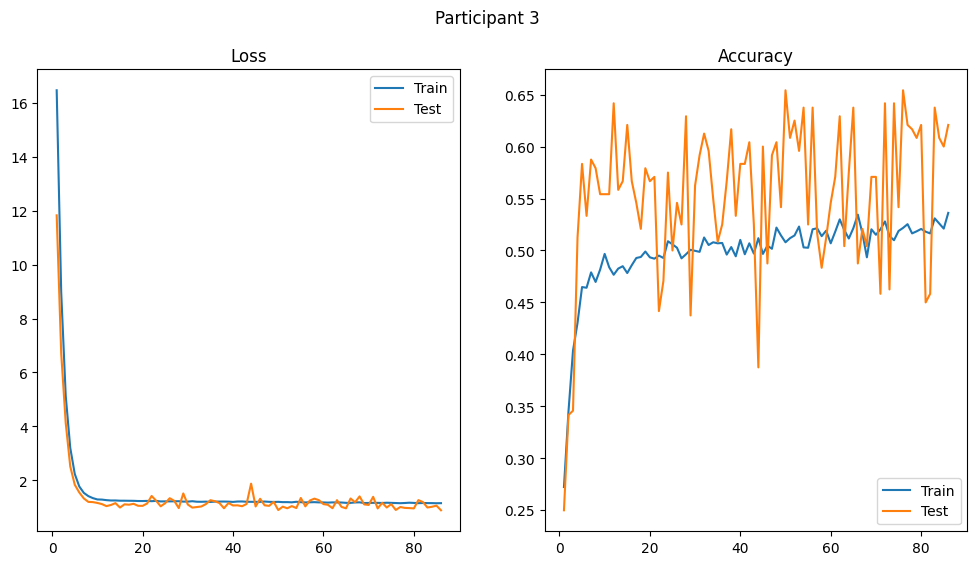

Outer Loop 12 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [7]



Epoch 1/500
95/95 [==============================] - 14s 75ms/step - loss: 16.4475 - accuracy: 0.2480 - val_loss: 11.7357 - val_accuracy: 0.2500
Epoch 2/500
95/95 [==============================] - 6s 62ms/step - loss: 8.9537 - accuracy: 0.3013 - val_loss: 6.6755 - val_accuracy: 0.2500
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.1527 - accuracy: 0.3635 - val_loss: 4.0903 - val_accuracy: 0.3250
Epoch 4/500
95/95 [=======

<Figure size 640x480 with 0 Axes>

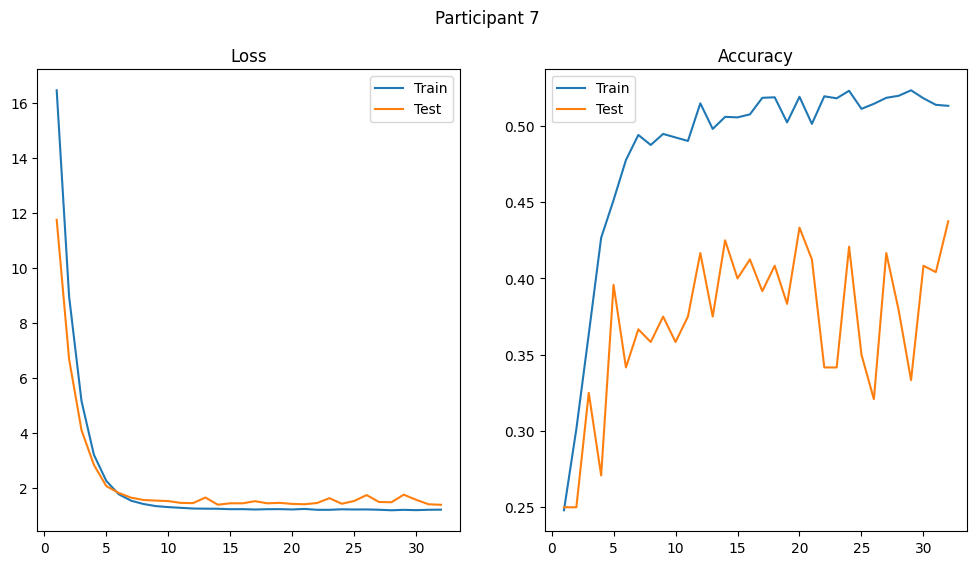

Outer Loop 13 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [15]



Epoch 1/500
95/95 [==============================] - 14s 75ms/step - loss: 16.6546 - accuracy: 0.2717 - val_loss: 11.9542 - val_accuracy: 0.2917
Epoch 2/500
95/95 [==============================] - 6s 62ms/step - loss: 9.1137 - accuracy: 0.3178 - val_loss: 6.7725 - val_accuracy: 0.2833
Epoch 3/500
95/95 [==============================] - 6s 63ms/step - loss: 5.1972 - accuracy: 0.3872 - val_loss: 4.2034 - val_accuracy: 0.3458
Epoch 4/500
95/95 [=======

<Figure size 640x480 with 0 Axes>

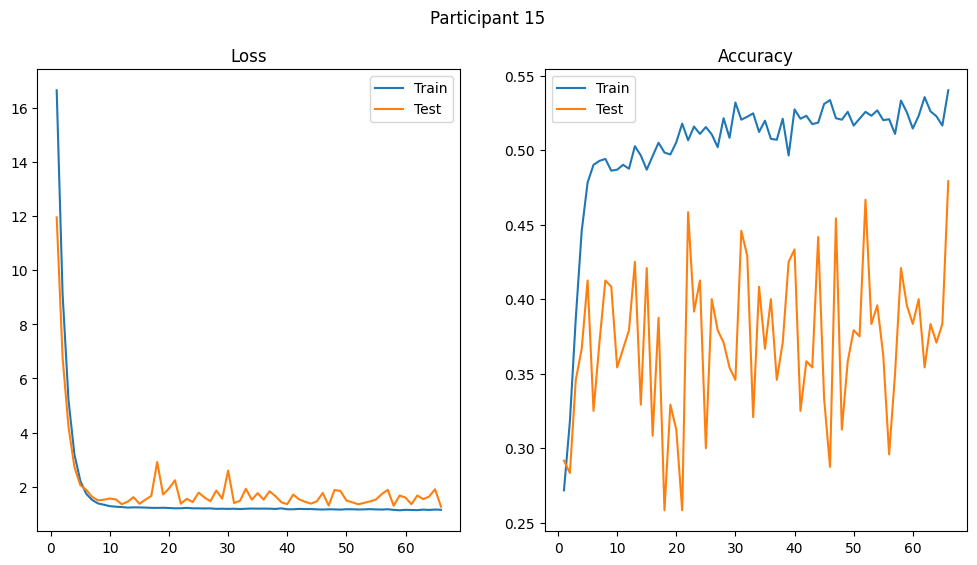

Outer Loop 14 

      Train epochs' shape:                                (3040, 1, 64, 1123)
      Test epochs' shape:                                 (240, 1, 64, 1123)
      Test labels' shape:                                 (240, 4)
      Train labels' shape (without encoding):             (3040, 1)
      Test labels' shape (without encoding):              (240, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
      Test index:                                         [14]



Epoch 1/500
95/95 [==============================] - 15s 77ms/step - loss: 15.8904 - accuracy: 0.2641 - val_loss: 11.4323 - val_accuracy: 0.2375
Epoch 2/500
95/95 [==============================] - 6s 65ms/step - loss: 8.6908 - accuracy: 0.3418 - val_loss: 6.5304 - val_accuracy: 0.2958
Epoch 3/500
95/95 [==============================] - 6s 65ms/step - loss: 4.9992 - accuracy: 0.4201 - val_loss: 4.0111 - val_accuracy: 0.3292
Epoch 4/500
95/95 [=======

<Figure size 640x480 with 0 Axes>

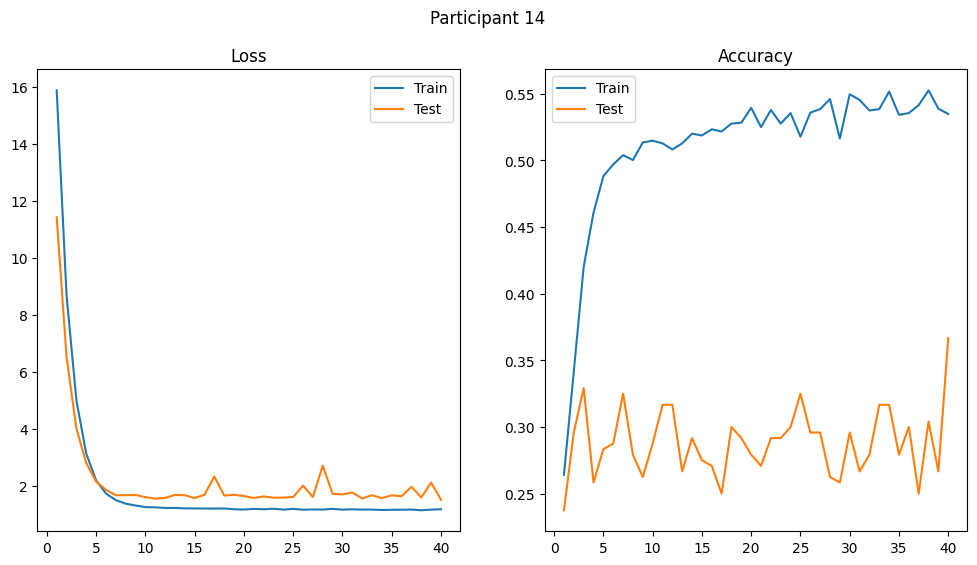

Outer Loop 15 

      Train epochs' shape:                                (3200, 1, 64, 1123)
      Test epochs' shape:                                 (80, 1, 64, 1123)
      Test labels' shape:                                 (80, 4)
      Train labels' shape (without encoding):             (3200, 1)
      Test labels' shape (without encoding):              (80, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [9]



Epoch 1/500
100/100 [==============================] - 14s 71ms/step - loss: 15.6010 - accuracy: 0.2547 - val_loss: 11.0317 - val_accuracy: 0.3125
Epoch 2/500
 82/100 [=======================>......] - ETA: 1s - loss: 8.7002 - accuracy: 0.3209

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [31]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009
patience = 50


kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    # Define early stopping
    # early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # All_models = KerasClassifier(model=EEGNet_Modified, epochs=1, 
    #                              nb_classes=4, Chans=64, Samples=1123, dropoutRate=0.4, 
    #                              kernLength=64, F1=8, D=4, F2=32, norm_rate=0.25, dropoutType=Dropout,
    #                              learning_rate=0.0009)

    
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # # Define hyperparameters and values to search
    # param_grid = {
    #     'nb_classes': [4],
    #     'Chans': [64],
    #     'Samples': [1123],
    #     'dropoutRate': [0.2, 0.4, 0.5],
    #     'kernLength': [32, 64, 125, 150, 300, 500],
    #     'F1': [8],
    #     'D': [4],
    #     'F2': [32],
    #     'norm_rate': [0.25],
    #     'dropoutType': ['Dropout'],
    #     'learning_rate': [0.005],
    # }
    
    
    
    
    
    # random_search = RandomizedSearchCV(estimator=All_models, param_distributions=param_grid, cv=2, verbose=1, n_iter=1)
   
    
#     RS_result = random_search.fit(norm_train_epochs, train_labels)
    
#     best_parameters = RS_result.best_params_
    
    
#     print("--------Best Parammeters for this set----------\n\n")
#     print("         ", best_parameters, '\n\n')
#     print("-------------------END-------------------------")
#     with open("Best_hyperparameters_CS_Hadi.txt", 'a') as f:
#         json_string = json.dumps(best_parameters)
#         f.write('\n' + json_string)
#         f.close()
    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    
#     best_model = EEGNet_Modified(**best_parameters)
    
    # history = best_model.fit(
    #     norm_train_epochs, train_labels,
    #     validation_data=(norm_test_epochs, test_labels),
    #     epochs=max_epochs,
    #     batch_size=32,  # Adjust as needed
    #     callbacks=[early_stopping]
    # )
    
    # trans_train_epochs = np.transpose(norm_train_epochs, (0, 2, 1, 3)).squeeze()
    # trans_test_epochs = np.transpose(norm_test_epochs, (0, 2, 1, 3)).squeeze()
    
    # model = EEGNet(nb_classes=4, Chans = 64, Samples = 1123, 
    #                dropoutRate = 0.5, kernLength = 64, F1 = 8, 
    #                D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout',
    #                learning_rate=learning_rate)

    
    dataset = 'BCI2a'
    in_samples = 1123                   # Changed!!!
    n_channels = 64
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    
    
    # Set dataset paramters as dataset configuration
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_channels': n_channels, 'in_samples': in_samples, 'isStandard': True, 'LOSO': True}


    # Set training hyperparamters as train configuration
    train_conf = { 'batch_size': 64, 'epochs': 1123, 'patience': 50, 'lr': 0.001,
                  'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

    model = getModel(train_conf.get('model'), dataset_conf)
    

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])
    
    
    history = model.fit(
        train_epochs, train_labels,
        validation_data=(test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=32,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    # y_pred_test = best_model.predict(norm_test_epochs)
    # y_true_test = test_labels
    
    y_pred_test = model.predict(test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [32]:
best_estimator

<function __main__.EEGNet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', learning_rate=0.0009)>

In [28]:
RS_result.best_params_

{'norm_rate': 0.25,
 'nb_classes': 4,
 'learning_rate': 0.005,
 'kernLength': 64,
 'dropoutType': 'SpatialDropout2D',
 'dropoutRate': 0.4,
 'Samples': 1123,
 'F2': 16,
 'F1': 8,
 'D': 2,
 'Chans': 64}

In [36]:
All_models.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'nb_epochs', 'class_weight'])

In [41]:
print(All_models.get_params().keys())


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'nb_classes', 'Chans', 'Samples', 'class_weight'])


In [35]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(2, 16):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-2]
    y_pred = all_y_pred[i-2]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [37]:
len(confusion_matrices)

14

In [52]:
confusion_matrices[7] = np.pad(confusion_matrices[7], (0, 2))

In [53]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [31]:
summation.sum(axis=1)

Left (True)      599
Right (True)     602
Feet (True)      601
Tongue (True)    602
dtype: int64

In [34]:
acc

NameError: name 'acc' is not defined

In [54]:
print("Dataset: Hadi - Phase 2 (4-Class)")
print("The cross-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: ", acc)

normalized

Dataset: Hadi - Phase 2 (4-Class)
The cross-subject scenario:
Algorithm: ATCNet
Accuracy:  0.5144144144144145


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.661728,0.164198,0.077778,0.096296
Right (True),0.203704,0.671605,0.053086,0.071605
Feet (True),0.224324,0.114865,0.216216,0.444595
Tongue (True),0.145946,0.114865,0.231081,0.508108


In [72]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

4

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred)
class 1 (True),358,162
class 2 (True),202,315


In [31]:
summation / 520

,class 1 (Pred),class 2 (Pred)
class 1 (True),0.688462,0.311538
class 2 (True),0.388462,0.605769


In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

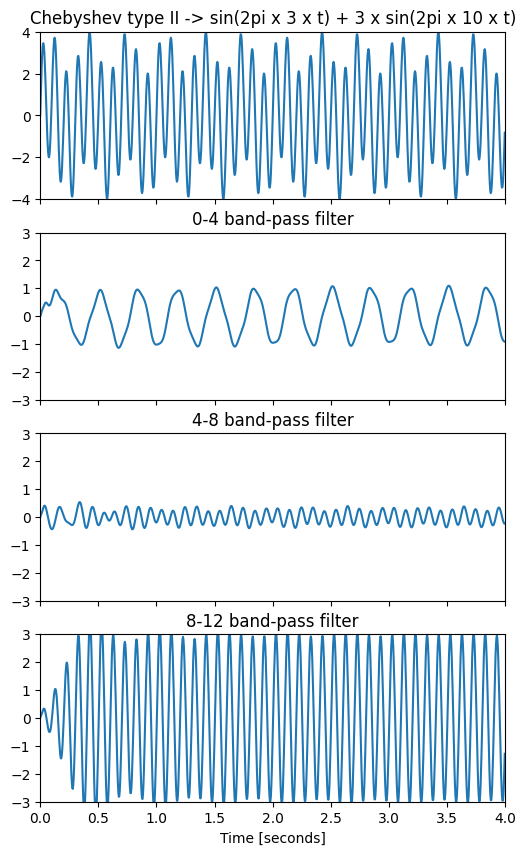

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


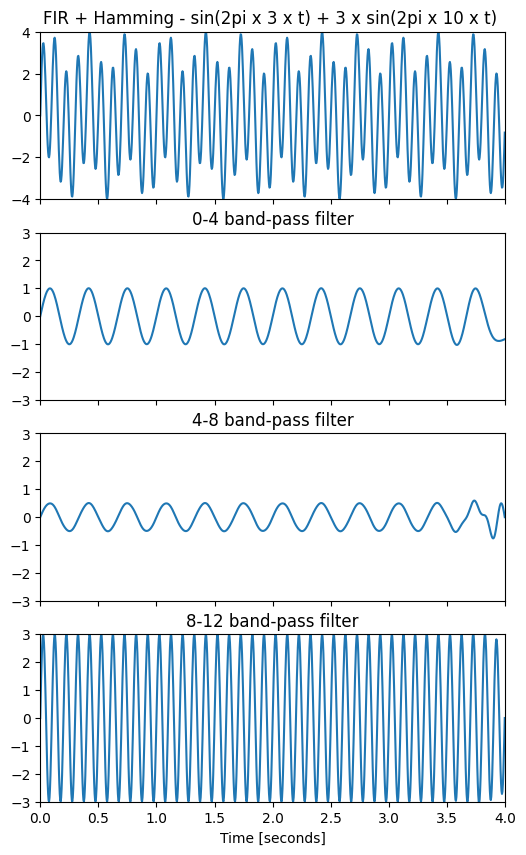

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

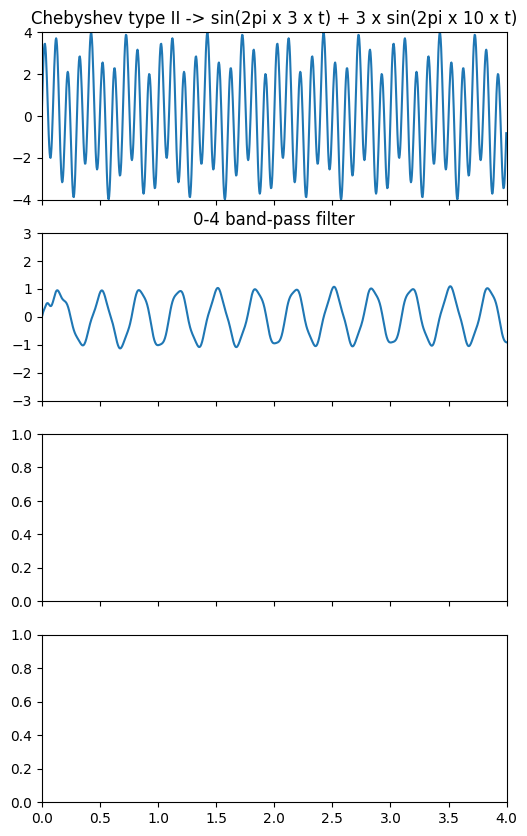

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

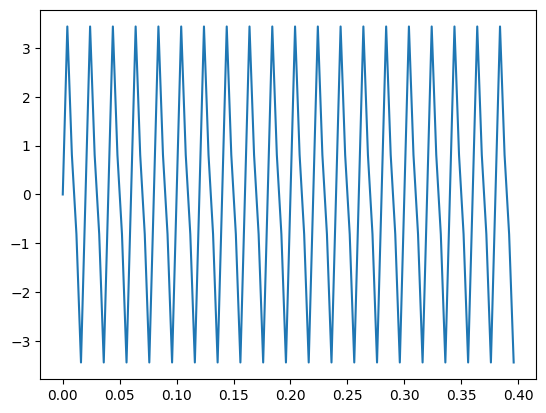

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

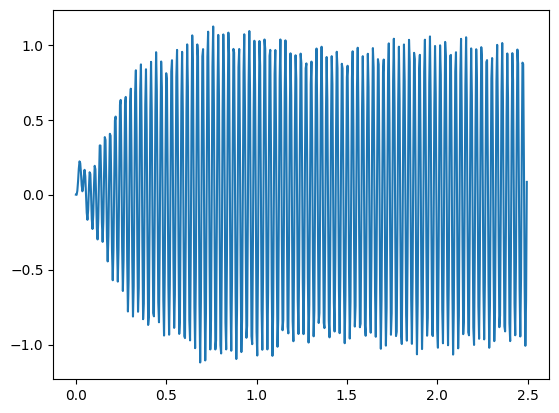

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

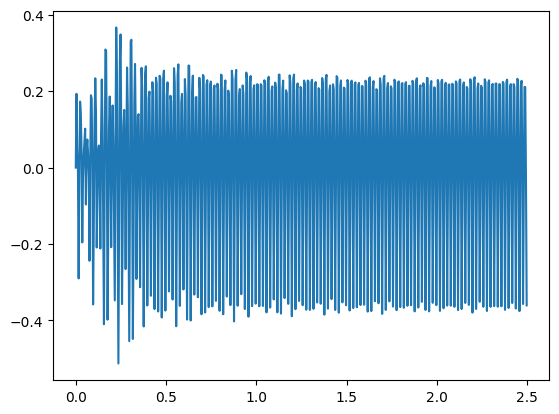

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

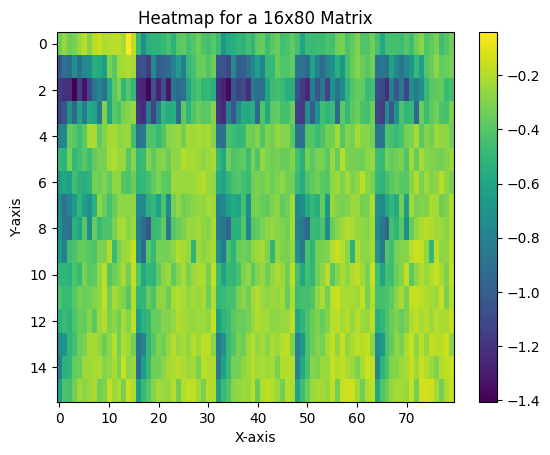

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

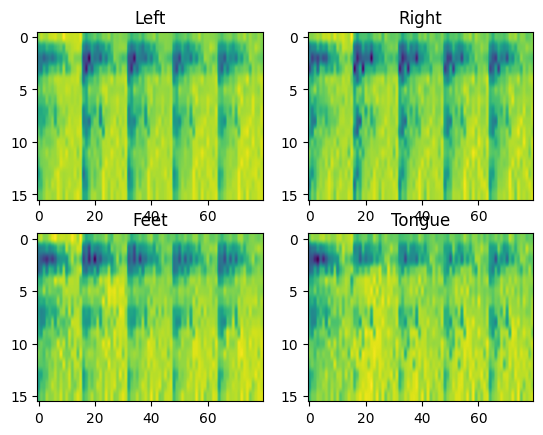

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()